Load Libraries & Data

In [1]:
import sys
import os

# Go up one directory to access 'src/'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils import shuffle
import joblib
import os
import scipy.stats as stats
from itertools import combinations
from data_processing import preprocess, cramers_v

# Load data
train_data = pd.read_excel("../data/raw/train_file.xlsx")


Quick Data Overview

In [2]:
# First look at the dataset
print(train_data.head())   # Shows the first 5 rows
print(train_data.info())   # Shows data types & missing values
print(train_data.describe(include='all'))  

   age           job   marital          education  default housing loan  \
0   49   blue-collar   married           basic.9y  unknown      no   no   
1   37  entrepreneur   married  university.degree       no      no   no   
2   78       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   59       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign  previous     poutcome    y  
0   cellular   nov         wed       227         4         0  nonexistent   no  
1  telephone   nov         wed       202         2         1      failure   no  
2   cellular   jul         mon      1148         1         0  nonexistent  yes  
3  telephone   may         mon       120         2         0  nonexistent   no  
4   cellular   jun         tue       368         2         0  nonexistent   no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries

Analyze Numerical Features

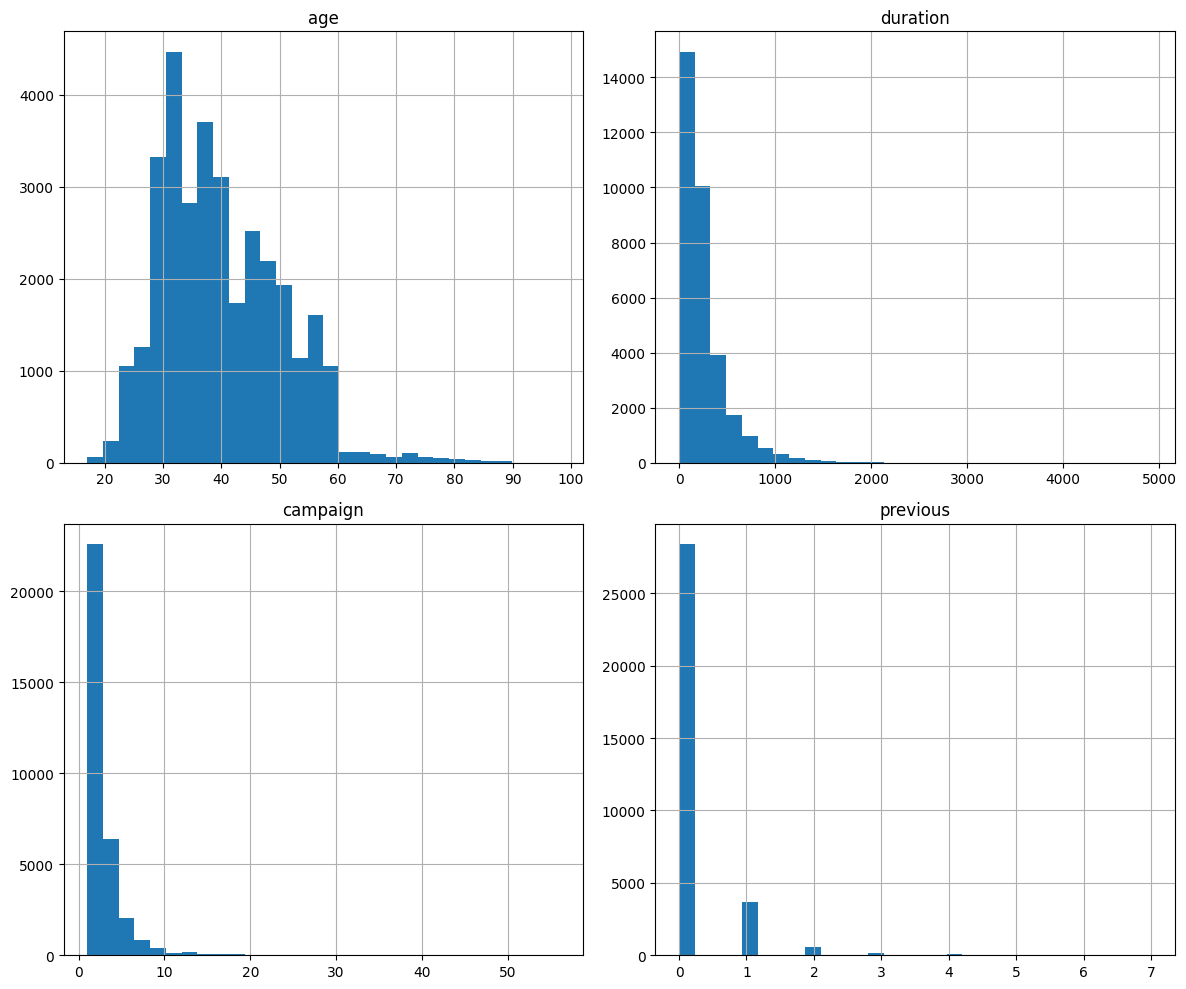

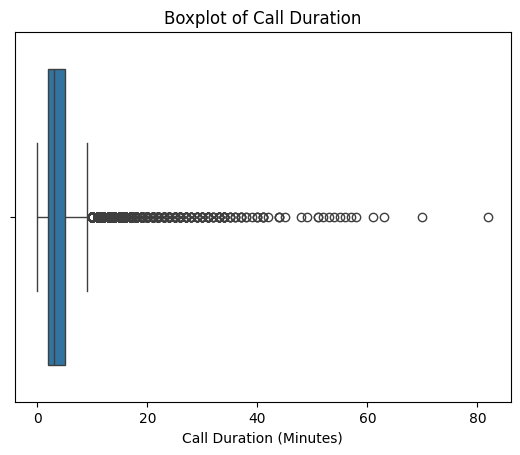

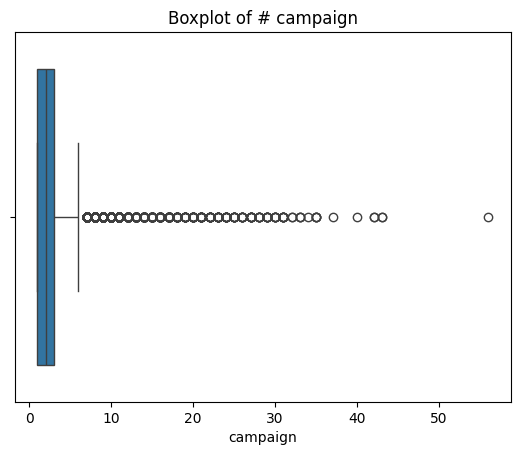

In [3]:
# Identify categorical and numerical columns
categorical_features = train_data.select_dtypes(include=['object', 'category']).columns
numerical_features = train_data.select_dtypes(include=['number']).columns


# Plot histograms for numerical features
train_data[numerical_features].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# Boxplot for 'duration' (Call Duration)
duration_minutes= round(train_data['duration']/60) # convert to minutes for ease of interpretation
sns.boxplot(x=duration_minutes)
plt.xlabel("Call Duration (Minutes)")
plt.title("Boxplot of Call Duration")
plt.show()



# Boxplot for '# campaign' 
sns.boxplot(x=train_data['campaign'])
plt.title("Boxplot of # campaign")
plt.show()

Analyze Categorical Features 

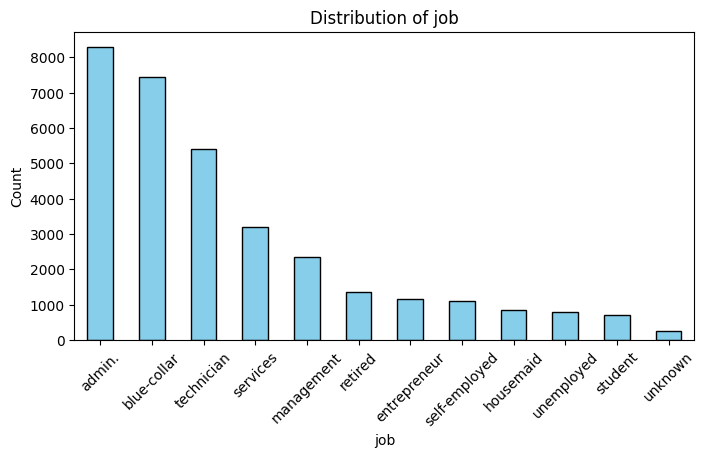

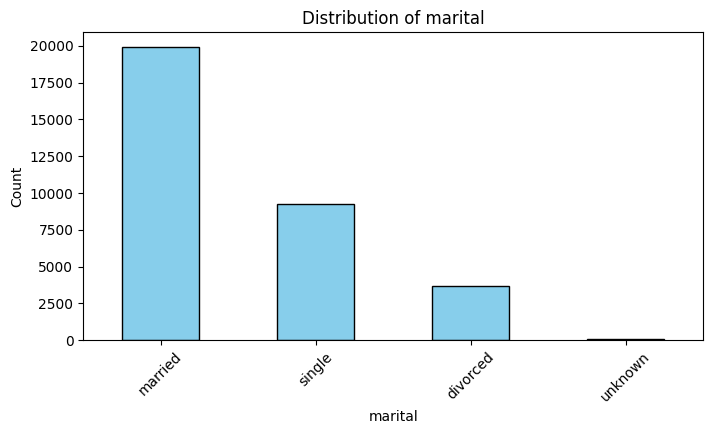

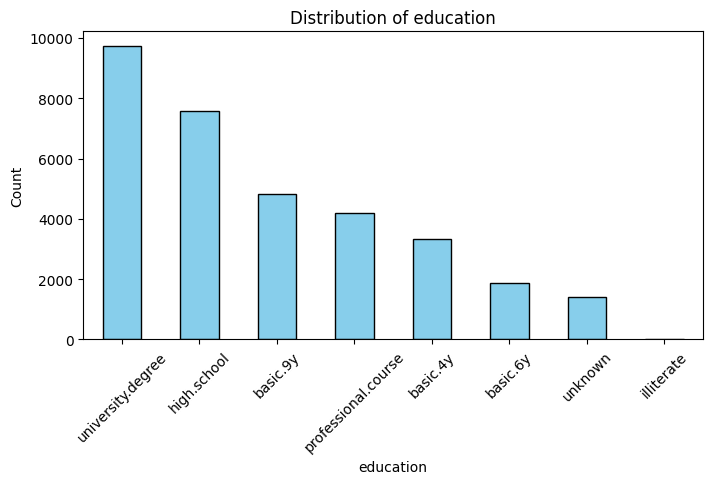

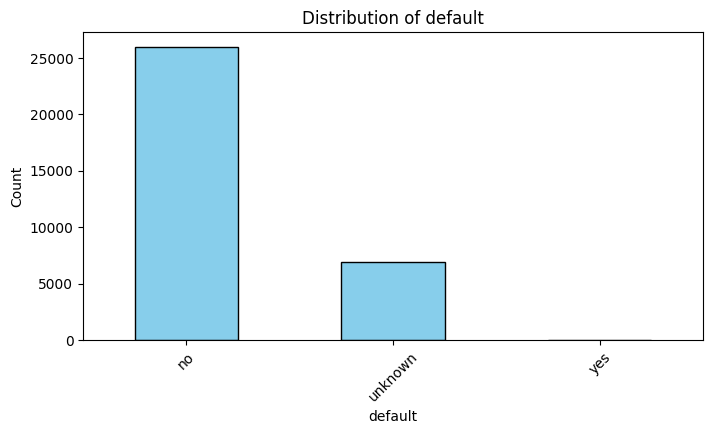

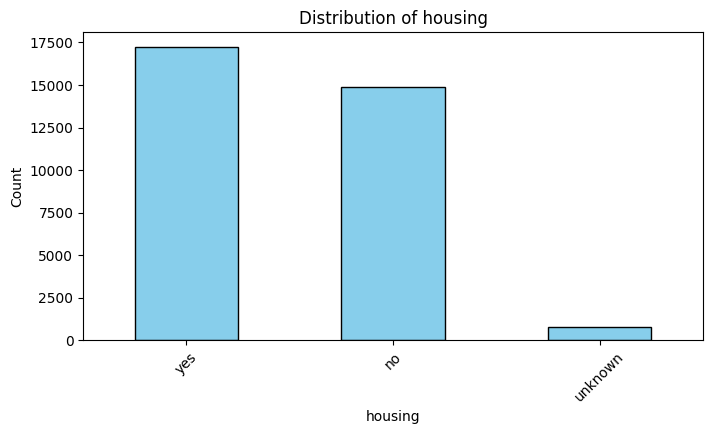

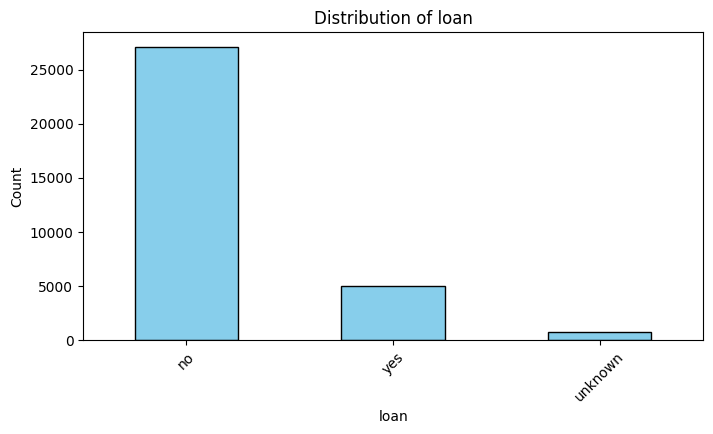

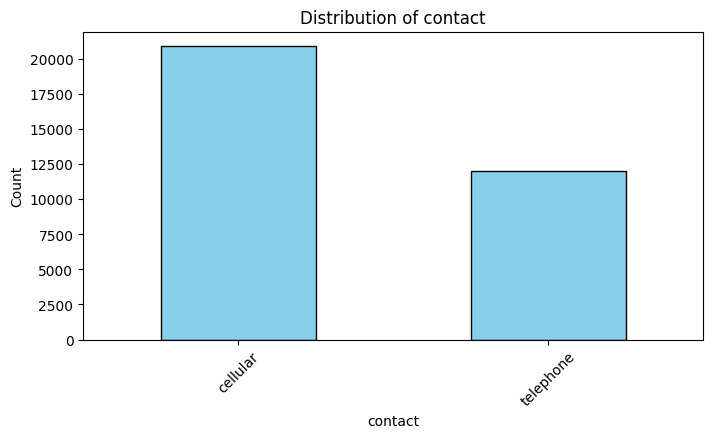

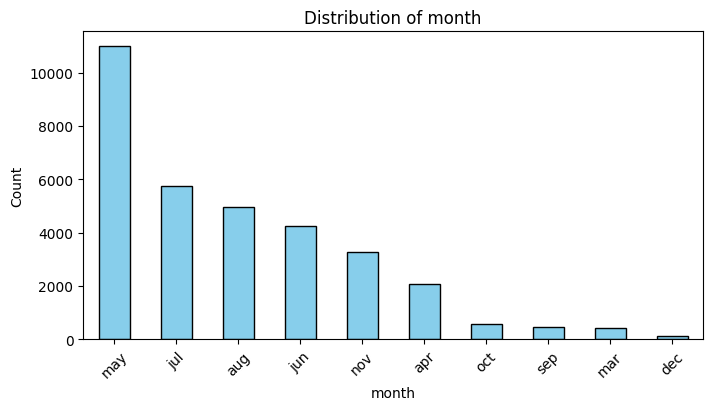

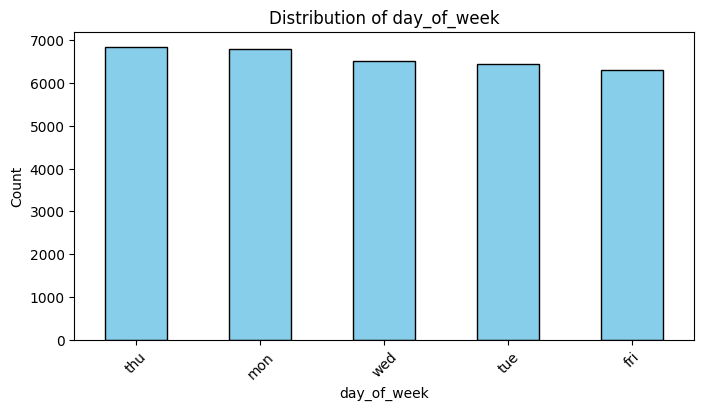

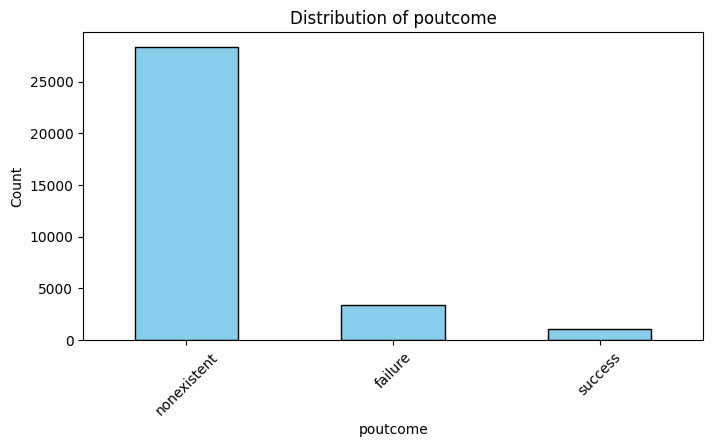

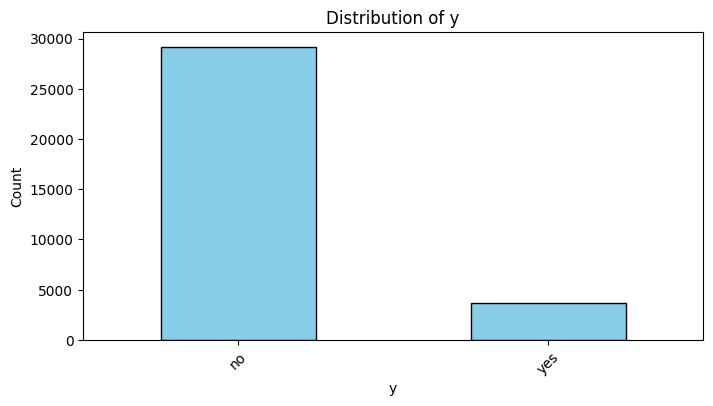

In [4]:
# Plot bar charts for categorical features
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    train_data[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


Analyze Associations between Categorical Features 

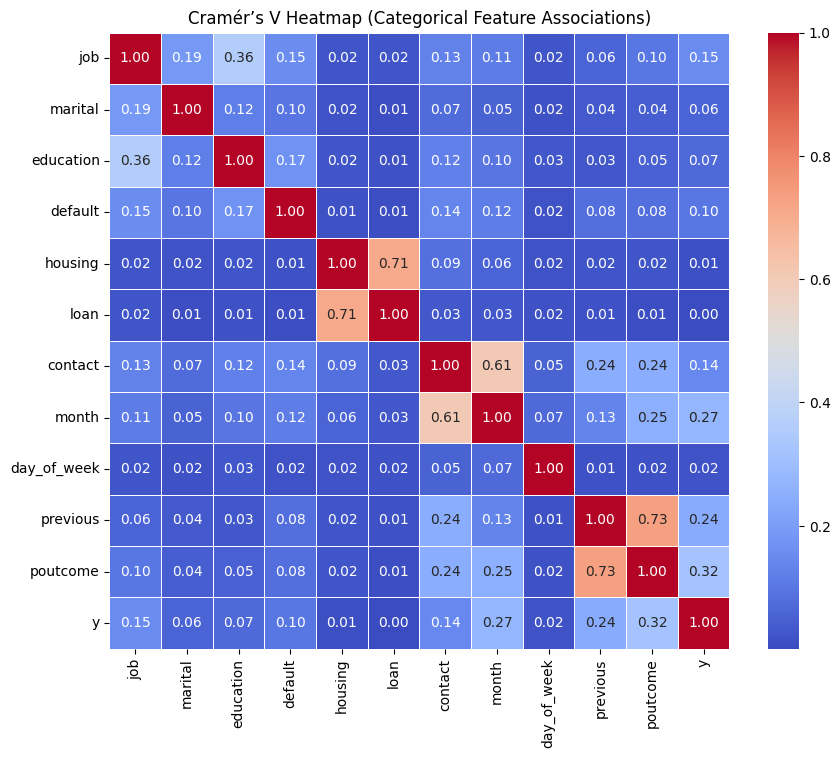


Top Feature Associations Based on Cramér’s V:

     Feature 1  Feature 2  Cramér’s V
118   previous   poutcome    0.733630
129   poutcome   previous    0.733630
53     housing       loan    0.707897
64        loan    housing    0.707897
79     contact      month    0.607908
90       month    contact    0.607908
2          job  education    0.360001
24   education        job    0.360001
142          y   poutcome    0.320424
131   poutcome          y    0.320424


In [5]:


# Detect categorical columns (including ordinal categories with <15 unique values)
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object' or train_data[col].nunique() < 15]

# Compute Cramér’s V for all unique pairs of categorical columns
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

for col1, col2 in combinations(categorical_columns, 2):
    contingency_table = pd.crosstab(train_data[col1], train_data[col2])
    cramers_v_matrix.loc[col1, col2] = cramers_v(contingency_table)
    cramers_v_matrix.loc[col2, col1] = cramers_v(contingency_table)  # Symmetric

np.fill_diagonal(cramers_v_matrix.values, 1)  # Set diagonal values to 1

# Display Cramér’s V heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér’s V Heatmap (Categorical Feature Associations)")
plt.show()

# Display the ranked associations
cramers_v_df = cramers_v_matrix.unstack().reset_index()
cramers_v_df.columns = ["Feature 1", "Feature 2", "Cramér’s V"]
cramers_v_df = cramers_v_df[cramers_v_df["Feature 1"] != cramers_v_df["Feature 2"]]  # Remove diagonal
cramers_v_df = cramers_v_df.sort_values(by="Cramér’s V", ascending=False)

print("\nTop Feature Associations Based on Cramér’s V:\n")
print(cramers_v_df.head(10))

Analyze Associations between Numerical Features  

In [6]:
# Detect numerical columns (excluding target variable 'y')
numerical_columns = [col for col in train_data.columns if train_data[col].dtype in ['int64', 'float64'] and col != 'y']

# Dictionary to store correlation results
correlation_results = {}

# Generate unique feature pairs (no duplicates like (A, B) and (B, A))
unique_pairs = list(combinations(numerical_columns, 2))

# Loop through unique numerical feature pairs and apply Pearson & Spearman correlation tests
for col1, col2 in unique_pairs:
    # Pearson correlation (linear relationships)
    pearson_corr, pearson_p = stats.pearsonr(train_data[col1], train_data[col2])
    
    # Spearman correlation (monotonic relationships, less sensitive to outliers)
    spearman_corr, spearman_p = stats.spearmanr(train_data[col1], train_data[col2])

    # Store correlation values and p-values
    correlation_results[(col1, col2)] = {
        "Pearson Corr": round(pearson_corr, 5),
        "Pearson p-value": round(pearson_p, 5),
        "Spearman Corr": round(spearman_corr, 5),
        "Spearman p-value": round(spearman_p, 5),
    }

# Convert results to DataFrame and sort by Spearman p-value
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index').sort_values(by='Spearman p-value')
# Display results
print(correlation_df)

                   Pearson Corr  Pearson p-value  Spearman Corr  \
duration campaign      -0.07565          0.00000       -0.08399   
         previous       0.02258          0.00004        0.04476   
campaign previous      -0.07897          0.00000       -0.08672   
age      previous       0.02079          0.00016       -0.01592   
         campaign       0.00341          0.53662        0.00460   
         duration      -0.00174          0.75217       -0.00074   

                   Spearman p-value  
duration campaign           0.00000  
         previous           0.00000  
campaign previous           0.00000  
age      previous           0.00387  
         campaign           0.40444  
         duration           0.89319  
